In [29]:
from HeaderP import *
import Astraea
import pandas as pd
import glob
import os
import starspot as ss
from starspot import sigma_clipping
import starspot.rotation_tools as rt
import matplotlib
matplotlib.use('Agg')

In [ ]:
splitNo=144000
Periods_acf=np.zeros((3000,20))
Periods_LG=np.zeros((3000,20))
LG_peaks=np.zeros((3000,20))
ACF_peaks=np.zeros((3000,20))
KIDs=[]
starcount=0

In [ ]:
StarN='kplr005094751'
# count lines
Nline=0
with open('./KOIlcs/download_exoarch_20015_6.bat', 'r') as f:
    for line in f:
        Nline += 1
print('total number of lines',Nline)

with open('./KOIlcs/download_exoarch_20015_6.bat') as f:
    for i in range(9):
        f.readline()
    
    allData_time=[]
    allData_sig=[]
    allData_sig_err=[]
    for i in range(Nline-9):
        update_progress(i/(Nline-9))
        line=f.readline()
        if 'tbl' not in line:
            StarN_new=line.split('.fits')[0].split(" '")[1].split('-')[0]
            filename=line.split(" '")[1].split('fits')[0]+'fits'
            print(filename)
            if StarN_new==StarN:
                os.system(line)
                data=readfits(filename)
                data=data.dropna(subset=['TIME','PDCSAP_FLUX'])
                allData_time.append(data.TIME)
                allData_sig.append(data.PDCSAP_FLUX/np.median(data.PDCSAP_FLUX)-1)
                allData_sig_err.append(data.PDCSAP_FLUX_ERR/np.median(data.PDCSAP_FLUX))
                StarN=StarN_new
                os.system('rm '+filename)
            else:
                print('New Star!')
                time_r_all=np.array([item for sublist in allData_time for item in sublist])
                sig_r_all=np.array([item for sublist in allData_sig for item in sublist])
                sig_err_r_all=np.array([item for sublist in allData_sig_err for item in sublist])
                    
                # split into 3
                array_len=len(time_r_all)
                print(array_len)
                split_len=int(np.ceil(float(array_len)/splitNo))
                
                print(split_len)
                for i in range(split_len):
                    if i==split_len-1:
                        time_r=time_r_all[i*splitNo:]
                        sig_r=sig_r_all[i*splitNo:]
                        sig_err_r=sig_err_r_all[i*splitNo:]
                        if split_len==1:
                            time_r=time_r_all[i*splitNo:]
                            sig_r=sig_r_all[i*splitNo:]
                            sig_err_r=sig_err_r_all[i*splitNo:]
                        elif len(time_r)<splitNo/2:
                            continue
                    else:
                        time_r=time_r_all[i*splitNo:i*splitNo+splitNo]
                        sig_r=sig_r_all[i*splitNo:i*splitNo+splitNo]
                        sig_err_r=sig_err_r_all[i*splitNo:i*splitNo+splitNo]
                    
                    med = np.median(sig_r)
                
                    m = sigma_clipping.sigma_clip(sig_r, nsigma=6)
                    x, y, yerr = time_r[m], sig_r[m], sig_err_r[m]
                
                    smooth, mask = sigma_clipping.filter_sigma_clip(x, y, window_length=199)
                
                    time, sig, sig_err = x[mask], y[mask], yerr[mask]
                
                    rotate = ss.RotationModel(time, sig, sig_err)
                    ls_period = rotate.ls_rotation()
                    tess_cadence=1./24./2.
                    acf_period = rotate.acf_rotation(tess_cadence)
                
                    peak_positions, peak_heights = rt.get_peak_statistics(1./rotate.freq, rotate.power)
                    acf_peak_positions, acf_peak_heights = rt.get_peak_statistics(rotate.lags, rotate.acf, sort_by="height")
                    
                    print(ls_period,acf_period,peak_heights[0],acf_peak_heights[0])
                    Periods_LG[starcount,i]=ls_period
                    Periods_acf[starcount,i]=acf_period
                    LG_peaks[starcount,i]=peak_heights[0]
                    ACF_peaks[starcount,i]=acf_peak_heights[0]
                    
                    
                print(starcount)
                KIDs.append(StarN)
                print(Periods_LG)
                
                rotate.big_plot(["ls", "acf"], method_xlim=(0, max([acf_period,ls_period])*1.5));
                plt.savefig('./pngs/'+StarN+'.png')
                
                allData_time=[]
                allData_sig=[]
                allData_sig_err=[]
                os.system(line)
                data=readfits(filename)
                data=data.dropna(subset=['TIME','PDCSAP_FLUX'])
                allData_time.append(data.TIME)
                allData_sig.append(data.PDCSAP_FLUX/np.median(data.PDCSAP_FLUX)-1)
                allData_sig_err.append(data.PDCSAP_FLUX_ERR/np.median(data.PDCSAP_FLUX)-1)
                StarN=StarN_new
                starcount=starcount+1
                os.system('rm '+filename) 
                

In [95]:
print(starcount)

1630


In [96]:
Prot_acf=pd.DataFrame(Periods_acf,columns=['Prot_acf'+str(i) for i in range(20)])
Prot_LG=pd.DataFrame(Periods_LG,columns=['Prot_lg'+str(i) for i in range(20)])
peak_acf=pd.DataFrame(ACF_peaks,columns=['peak_acf'+str(i) for i in range(20)])
peak_LG=pd.DataFrame(LG_peaks,columns=['peak_lg'+str(i) for i in range(20)])
Prot_acf['KIC']=np.zeros(3000)
Prot_acf['KIC'][0:len(KIDs)]=KIDs
frames = [Prot_acf, Prot_LG, peak_acf, peak_LG]
result = pd.concat(frames, axis=1, sort=False)
result.to_pickle('Periods.pkl')

In [18]:
Periods_acf=np.zeros((3000,5))
len(Periods_acf[0])

5

In [199]:
LGs=pd.DataFrame(np.array(Periods_LG))

datas=pd.DataFrame(np.array((KIDs,Periods_LG,Periods_acf,)).T,columns=['KID','LG','acf'])
datas['periods']=datas['acf']



In [269]:
print(StarN)
#(KIDs,Periods_LG,Periods_acf)

kplr005780885


In [305]:
datas.periods[datas['KID']=='kplr009529744']=Periods_LG[-1]

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [306]:
datas[datas['KID']=='kplr009529744']

,KID,LG,acf,periods
691,kplr009529744,2.404395471227754,2.291667,12.4423


In [256]:
kid='kplr005780885'
datas.periods[datas['KID']==kid]=datas.LG[datas['KID']==kid]

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [315]:
datas['KIDs']=[int(datas['KID'][i][4:]) for i in range(len(datas))]

In [316]:
datas

,KID,LG,acf,periods,KIDs
0,kplr010000941,13.374822447456486,12.937500,13.374822447456486,10000941
1,kplr010001368,11.769628405576034,1.041667,11.769628405576034,10001368
2,kplr010002866,10.981419252816762,11.062500,11.0625,10002866
3,kplr010004519,3.268460284868773,1.062500,3.268460284868773,10004519
4,kplr010004738,23.060479017060313,1.041667,23.060479017060313,10004738
...,...,...,...,...,...
1627,kplr011187436,4.561016058585926,4.604167,4.604166666666666,11187436
1628,kplr011189311,4.933968045329805,5.166667,5.166666666666666,11189311
1629,kplr011192998,11.658237676536627,1.041667,11.658237676536627,11192998
1630,kplr011193263,11.210549681168779,1.041667,11.210549681168779,11193263


In [317]:
print(len(KIDs))
datas.to_pickle('Prots.pkl')


1647


In [128]:
line.split(" '")[1].split('fits')[0]+'fits'

'kplr010000162-2010174085026_llc.fits'

In [178]:
max([acf_period,ls_period])[0]*1.5

IndexError: invalid index to scalar variable.

In [14]:
filenames=glob.glob("./KOIlcs/*.fits")

./KOIlcs/kplr010000162-2009259160929_llc.fits
./KOIlcs/kplr010000162-2010265121752_llc.fits
./KOIlcs/kplr010000162-2010355172524_llc.fits
./KOIlcs/kplr010000162-2011073133259_llc.fits
./KOIlcs/kplr010000162-2010174085026_llc.fits
./KOIlcs/kplr010000162-2011271113734_llc.fits
./KOIlcs/kplr010000162-2009166043257_llc.fits
./KOIlcs/kplr010000162-2009350155506_llc.fits
./KOIlcs/kplr010000162-2011177032512_llc.fits
./KOIlcs/kplr010000162-2012004120508_llc.fits
./KOIlcs/kplr010000162-2012088054726_llc.fits
./KOIlcs/kplr010000162-2010078095331_llc.fits


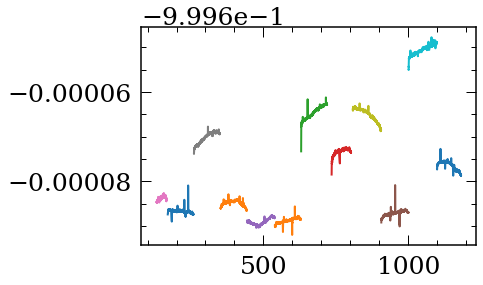

In [129]:
for file in filenames:
    print(file)
    data=readfits(file)
    data=data.dropna(subset=['TIME','PDCSAP_FLUX'])
    plt.plot(data.TIME,data.PDCSAP_FLUX_ERR/np.median(data.PDCSAP_FLUX)-1)


In [2]:
Periods_acf=[[] for i in range(5)]

In [5]:
Periods_acf[0].append(1)

In [6]:
Periods_acf

[[1], [], [], [], []]